In [0]:
!pip install h20gpu
import h2ogpu as sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

ERROR: Could not find a version that satisfies the requirement h20gpu (from versions: none)
ERROR: No matching distribution found for h20gpu


ModuleNotFoundError: ignored

In [0]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-28 19:07:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2020-04-28 19:07:46 (32.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [0]:
raw_data = pd.read_csv('loan_train.csv')
raw_data.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [0]:
raw_data = raw_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
raw_data.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


Drop the date related columns, effective_date & due_date. Map the Gender & loan_status columns to 0s and 1s.

In [0]:
data = raw_data.drop(['effective_date', 'due_date'], axis = 1)
data['Gender'] = data['Gender'].map({'male': 0, 'female': 1})
data['loan_status'] = data['loan_status'].map({'COLLECTION': 0, 'PAIDOFF': 1})
data.count()

loan_status    346
Principal      346
terms          346
age            346
education      346
Gender         346
dtype: int64

Create dummies for the education column.

In [0]:
dummies = pd.get_dummies(data['education'], prefix='edu').astype('float')
print(type(dummies))
dummies.head()

<class 'pandas.core.frame.DataFrame'>


,edu_Bechalor,edu_High School or Below,edu_Master or Above,edu_college
0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


Rename the column names for consistency.

In [0]:
dummies.columns = ['edu_bachelor', 'edu_hs_or_lower', 'edu_master_or_higher', 'edu_college']
dummies = dummies.drop('edu_master_or_higher', axis = 1)
dummies.count()

edu_bachelor       346
edu_hs_or_lower    346
edu_college        346
dtype: int64

In [0]:
data.count()

loan_status    346
Principal      346
terms          346
age            346
education      346
Gender         346
dtype: int64

Drop education column and merge education dummies with dataset

In [0]:
x = data.drop('education', axis = 1)
x = x.join(dummies)
print(type(x), x.count())
# for i in range(len(x.index)):
#     x['edu_bachelor'][i] = dummies['edu_bachelor'][i]
#     x['edu_hs_or_lower'][i] = dummies['edu_hs_or_lower'][i]
#     x['edu_college'][i] = dummies['edu_college'][i]
x.head()

<class 'pandas.core.frame.DataFrame'> loan_status        346
Principal          346
terms              346
age                346
Gender             346
edu_bachelor       346
edu_hs_or_lower    346
edu_college        346
dtype: int64


,loan_status,Principal,terms,age,Gender,edu_bachelor,edu_hs_or_lower,edu_college
0,1,1000,30,45,0,0.0,1.0,0.0
1,1,1000,30,33,1,1.0,0.0,0.0
2,1,1000,15,27,0,0.0,0.0,1.0
3,1,1000,30,28,1,0.0,0.0,1.0
4,1,1000,30,29,0,0.0,0.0,1.0


In [0]:
y = x['loan_status']
y = y.values
x = x.drop('loan_status', axis = 1)

Normalize the following columns, Principal, terms & age.

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()
x_np = x.values
x_scaled = min_max_scaler.fit_transform(x_np)
x_scaled

array([[1.        , 1.        , 0.81818182, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 0.45454545, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.34782609, 0.27272727, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.71428571, 0.34782609, 0.63636364, ..., 0.        , 0.        ,
        1.        ],
       [1.        , 1.        , 0.3030303 , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 1.        , 0.24242424, ..., 0.        , 0.        ,
        1.        ]])

Create training and testing data

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2)

In [0]:
from sklearn.metrics import jaccard_score, f1_score, log_loss

K-Nearest Neighbor:

In [0]:
from sklearn.neighbors import KNeighborsClassifier

def find_best_knn(k):
    knn_predictions = []
    for k_ in range(1, k):
        knn = KNeighborsClassifier(n_neighbors = k_, n_jobs = -1)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        y_pred_proba = knn.predict_proba(x_test)
        score = knn.score(x_test, y_test)
        jaccard = jaccard_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        knn_predictions.append([y_pred, y_pred_proba, score, jaccard, f1])
    return knn_predictions

In [0]:
knn_predictions = find_best_knn(20)

In [0]:
knn_predictions[0][4]

0.7346938775510203

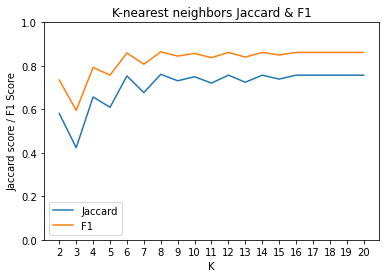

In [0]:
plt.plot([i + 2 for i in range(len(knn_predictions))],
         [knn_predictions[i][3] for i in range(len(knn_predictions))], label = 'Jaccard')
plt.plot([i + 2 for i in range(len(knn_predictions))],
         [knn_predictions[i][4] for i in range(len(knn_predictions))], label = 'F1')
plt.title('K-nearest neighbors Jaccard & F1')
plt.xlabel('K')
plt.ylabel('Jaccard score / F1 Score')
plt.ylim(0,1)
plt.xticks([i for i in range(2, 21)])
plt.legend()
plt.show()

Decision Tree:

In [0]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(x_train, y_train)
dec_tree_y_predict = dec_tree.predict(x_test)
dec_tree_y_predict_proba = dec_tree.predict_proba(x_test)
dec_tree_score = dec_tree.score(x_test, y_test)
dec_tree_f1_score = f1_score(y_test, dec_tree_y_predict)
dec_tree_jaccard_score = jaccard_score(y_test, dec_tree_y_predict)

In [0]:
dec_tree_f1_score, dec_tree_jaccard_score

(0.6947368421052631, 0.532258064516129)

Support vector machine:

In [0]:
from sklearn.svm import SVC

def test_poly_svm(poly_count):
    poly = []
    for p in range(poly_count):
        svm = SVC(kernel = 'poly', degree = p)
        svm.fit(x_train, y_train)
        y_pred = svm.predict(x_test)
        score = svm.score(x_test, y_test)
        f1 = f1_score(y_test, y_pred)
        jaccard = jaccard_score(y_test, y_pred)
        poly.append([y_pred, score, f1, jaccard])
    return poly

def svm_kernel_test():
    f1_ = []
    jaccard_ = []
    for kernel in ['linear', 'rbf', 'sigmoid']:
        svm = SVC(kernel = kernel)
        svm.fit(x_train, y_train)
        y_pred = svm.predict(x_test)
        score = svm.score(x_test, y_test)
        f1 = f1_score(y_test, y_pred)
        jaccard = jaccard_score(y_test, y_pred)
        f1_.append(f1)
        jaccard_.append(jaccard)
    return [f1_, jaccard_]

In [0]:
poly = 10
test_poly = test_poly_svm(poly)
kernel_comp = svm_kernel_test()

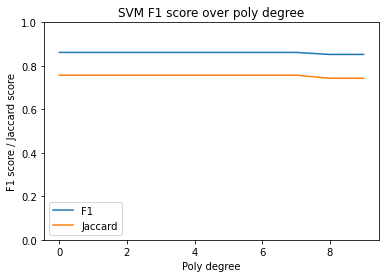

In [0]:
plt.plot([i for i in range(poly)],
         [test_poly[i][2] for i in range(len(test_poly))], label = 'F1')
plt.plot([i for i in range(poly)],
         [test_poly[i][3] for i in range(len(test_poly))], label = 'Jaccard')
plt.title('SVM F1 score over poly degree')
plt.xlabel('Poly degree')
plt.ylabel('F1 score / Jaccard score')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [0]:
(kernel_comp)

[[0.8617886178861789, 0.8617886178861789, 0.8429752066115702],
 [0.7571428571428571, 0.7571428571428571, 0.7285714285714285]]

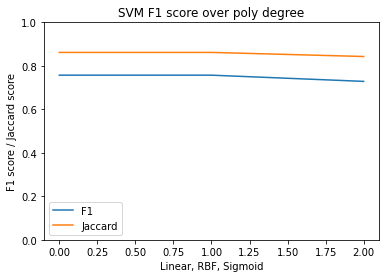

In [0]:
# plt.bar(0 - 2, [f for f in kernel_comp[0]], label = 'Jaccard')
# plt.bar(0, [j for j in kernel_comp[1]], label = 'F1')
# plt.title('Linear, RBF, Sigmoid SVMs')
# plt.ylabel('Score')
# plt.legend()
# plt.xticks(ticks = ['Linear', 'RBF', 'Sigmoid'])
# plt.show()

plt.plot([i for i in range(3)],
         [f for f in kernel_comp[1]], label = 'F1')
plt.plot([i for i in range(3)],
         [f for f in kernel_comp[0]], label = 'Jaccard')
plt.title('SVM F1 score over poly degree')
plt.xlabel('Linear, RBF, Sigmoid')
plt.ylabel('F1 score / Jaccard score')
plt.ylim(0, 1)
plt.legend()
plt.show()

Logistic regression:

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

log_reg_solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

def test_log_reg():
    f1_ = []
    jaccard_ = []
    log_loss_ = []
    for solver in log_reg_solvers:
        log_reg = LogisticRegression(solver = solver, n_jobs = -1)
        log_reg.fit(x_train, y_train)
        y_pred = log_reg.predict(x_test)
        f1 = f1_score(y_test, y_pred)
        jaccard = jaccard_score(y_test, y_pred)
        l_loss = log_loss(y_test, y_pred)
        f1_.append(f1)
        jaccard_.append(jaccard)
        log_loss_.append(l_loss)
    return [f1_, jaccard_, log_loss_]

In [0]:
log_reg_scores = test_log_reg()
log_reg_scores

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[[0.8617886178861789,
  0.8617886178861789,
  0.8617886178861789,
  0.8617886178861789,
  0.8617886178861789],
 [0.7571428571428571,
  0.7571428571428571,
  0.7571428571428571,
  0.7571428571428571,
  0.7571428571428571],
 [8.388182740997072,
  8.388182740997072,
  8.388182740997072,
  8.388182740997072,
  8.388182740997072]]

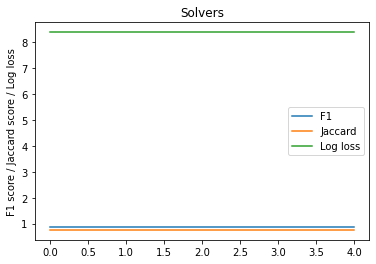

In [0]:
plt.plot([i for i in range(5)],
         [f for f in log_reg_scores[0]], label = 'F1')
plt.plot([i for i in range(5)],
         [j for j in log_reg_scores[1]], label = 'Jaccard')
plt.plot([i for i in range(5)],
         [l for l in log_reg_scores[2]], label = 'Log loss')
plt.title('Solvers')
plt.xlabel('')
# plt.ylim(0, 1)
plt.legend()
plt.show()